<h1>Inceptionv1 example</h1>


In [ ]:
#!pip install tensorflow

<h2>Build inception v1 neural network</h2>

In [ ]:
# libs
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras import layers, Model, Input, applications, Sequential
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import imghdr
import logging

<ipython-input-2-4f850886d76e>:20: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


<h3>Parameters</h3>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# parameters
input_gdim = 228
img_gdim = 28
rgb = 3
grayscale = 1

# model parameters
mp = {'input_shape':(input_gdim,input_gdim,rgb),
      'img_dimensions':(input_gdim,input_gdim),
      'img_width':input_gdim,
      'img_height':input_gdim,
      'color_mode': 'rgb',
      'classes':2,
      'epochs':50
      }
# data parameters
dp = {'path':"/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Entrega Final/datasets/clean/apples",
      'img_size':(img_gdim,img_gdim),
      'batch_size':32,
      'test_size':0.3,
      'img_to_gray':False
      }

ip ={
     'rh':'/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Entrega Final/datasets/clean/to_testing/red_healthy_apple.png',
     'rr':'/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Entrega Final/datasets/clean/to_testing/red_rotten_apple.png'
     }

parameters = {1:dp,2:mp,3:ip}

In [ ]:
path = parameters[1]['path']
print(f"Verificando la existencia de la ruta: {path}")
print("Existe:", os.path.exists(path))


Verificando la existencia de la ruta: /content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Entrega Final/datasets/clean/apples
Existe: True


In [ ]:
''' drive.mount(parameters[1]['path'] '''
''' os.listdir(parameters[1]['path']) '''

" os.listdir(parameters[1]['path']) "

<h2>Models</h2>

<h3>Custom</h3>

In [ ]:
# custom model
def build_customv1(input_shape,num_classes):
  input = layers.Input(shape=input_shape)
  cmodel = layers.Conv2D(32, (3, 3), activation='relu')(input)
  cmodel = layers.MaxPooling2D((2, 2))(cmodel)
  cmodel = layers.Conv2D(64, (3, 3), activation='relu')(cmodel)
  cmodel = layers.MaxPooling2D((2, 2))(cmodel)
  cmodel = layers.Conv2D(128, (3, 3), activation='relu')(cmodel)
  cmodel = layers.Flatten()(cmodel)
  cmodel = layers.Dense(256, activation='relu')(cmodel)
  cmodel = layers.Dropout(0.5)(cmodel)
  out_put = layers.Dense(num_classes, activation='softmax')(cmodel)

  cmodel = Model(inputs=input, outputs=out_put)
  return cmodel

<h3>Inception v1</h3>

In [ ]:
# inception v1
def inception_module(x, filters):
    # 1x1 conv
    conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)

    # 5x5 conv
    conv5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)

    # Max pooling
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate all
    output = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)

    return output

def build_googlenet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


<h3>VGG16</h3>

In [ ]:
def build_vgg16(input_shape=(224,224,3),num_classes=2):
  vgg16 = Sequential()
  vgg16.add(layers.Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))

  vgg16.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  vgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
  vgg16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
  vgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  vgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

  vgg16.add(layers.Flatten())
  vgg16.add(layers.Dense(units=4096,activation="relu"))
  vgg16.add(layers.Dense(units=4096,activation="relu"))
  vgg16.add(layers.Dense(units=num_classes, activation="softmax"))

  return vgg16

<h3>Helping functions</h3>

In [ ]:
# Plot training history
def plot_training_accuracy(hist,title):
  plt.plot(hist.history['accuracy'], label='accuracy')
  plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
# feature maps
def get_feature_maps(test_image=any,model=any,num_layers=4,cols=4):
  layer_outputs = [layer.output for layer in model.layers[:num_layers]]
  fmodel = Model(inputs=model.input, outputs=layer_outputs)
  feature_maps = fmodel.predict(test_image)

  # Plot the feature maps
  for layer_num, feature_map in enumerate(feature_maps, start=1):
      print(f"Visualizing layer {layer_num}")

      cols = cols
      rows = np.ceil(feature_map.shape[-1] / cols)
      fig = plt.figure(figsize=(2*cols, 2*rows))

      for i in range(0, feature_map.shape[-1]):
          fig.add_subplot(int(rows), int(cols), i+1)
          plt.imshow(feature_map[0, :, :, i], cmap='viridis')
          plt.axis('off')
      plt.tight_layout()
      plt.show()

In [ ]:
# load an image for test the model
def load_image(img_path, input_shape = (None,228,228,3),show=False):
    img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)

    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

<h3>Model build and compilation</h3>

In [ ]:
incv1 = build_googlenet(parameters[2]['input_shape'], parameters[2]['classes'])
vgg16 = build_vgg16(parameters[2]['input_shape'], parameters[2]['classes'])
custo = build_customv1(parameters[2]['input_shape'], parameters[2]['classes'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
custo.compile(optimizer=Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy']
               )
incv1.compile(optimizer=Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy']
               )
vgg16.compile(optimizer=Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy']
               )

<h2>Preprocessing data source</h2>

In [ ]:
"""
references
https://www.imatest.com/docs/iqfactors/#:~:text=Sharpness%2C%20distortion%2C%20vignetting%2C%20Lateral,clearly%20classified%20as%20good/bad.
https://en.innovatiana.com/post/image-classification-in-ai#:~:text=Quality%20and%20visual%20inspection.%20In%20manufacturing%2C%20image,scratches%2C%20non%2Dconforming%20dimensions%2C%20or%20other%20visible%20imperfections.
https://www.linkedin.com/advice/0/what-some-common-challenges-pitfalls-image-classification#:~:text=1%20Data%20quality%20One%20of%20the%20most,used%20for%20training%20and%20testing%20the%20algorithms.
"""

'\nreferences\nhttps://www.imatest.com/docs/iqfactors/#:~:text=Sharpness%2C%20distortion%2C%20vignetting%2C%20Lateral,clearly%20classified%20as%20good/bad.\nhttps://en.innovatiana.com/post/image-classification-in-ai#:~:text=Quality%20and%20visual%20inspection.%20In%20manufacturing%2C%20image,scratches%2C%20non%2Dconforming%20dimensions%2C%20or%20other%20visible%20imperfections.\nhttps://www.linkedin.com/advice/0/what-some-common-challenges-pitfalls-image-classification#:~:text=1%20Data%20quality%20One%20of%20the%20most,used%20for%20training%20and%20testing%20the%20algorithms.\n'

In [ ]:
# WARNING: this is only for numpy array loaded data format
class ImageQualityChecker:
    def __init__(self,
                 min_size_bytes=1024,  # 1KB
                 min_dimensions=(224, 224),
                 max_dimensions=(4096, 4096),
                 min_aspect_ratio=0.5,
                 max_aspect_ratio=2.0,
                 min_sharpness=50,  # Laplacian variance threshold
                 min_entropy=5.0,
                 allowed_formats=('jpeg', 'png', 'bmp','jpg'),
                 brightness_range=(0.15, 0.85)):  # Acceptable mean brightness range
        """
        Initialize the image quality checker with configurable thresholds.

        Args:
            min_size_bytes (int): Minimum file size in bytes
            min_dimensions (tuple): Minimum width and height
            max_dimensions (tuple): Maximum width and height
            min_aspect_ratio (float): Minimum width/height ratio
            max_aspect_ratio (float): Maximum width/height ratio
            min_sharpness (float): Minimum Laplacian variance for sharpness
            min_entropy (float): Minimum Shannon entropy for image complexity
            allowed_formats (tuple): Allowed image formats
            brightness_range (tuple): Acceptable mean brightness range (0-1)
        """
        self.min_size_bytes = min_size_bytes
        self.min_dimensions = min_dimensions
        self.max_dimensions = max_dimensions
        self.min_aspect_ratio = min_aspect_ratio
        self.max_aspect_ratio = max_aspect_ratio
        self.min_sharpness = min_sharpness
        self.min_entropy = min_entropy
        self.allowed_formats = allowed_formats
        self.brightness_range = brightness_range

        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def check_file_size(self, file_path):
        """Check if file meets minimum size requirements."""
        return os.path.getsize(file_path) >= self.min_size_bytes

    def check_format(self, file_path):
        """Verify if image format is supported."""
        try:
            fmt = imghdr.what(file_path)
            return fmt in self.allowed_formats
        except Exception:
            return False

    def check_dimensions(self, image):
        """Check if image dimensions are within acceptable range."""
        width, height = image.size
        if width < self.min_dimensions[0] or height < self.min_dimensions[1]:
            return False
        if width > self.max_dimensions[0] or height > self.max_dimensions[1]:
            return False
        return True

    def check_aspect_ratio(self, image):
        """Check if image aspect ratio is within acceptable range."""
        width, height = image.size
        aspect_ratio = width / height
        return self.min_aspect_ratio <= aspect_ratio <= self.max_aspect_ratio

    def calculate_sharpness(self, image_array):
        """Calculate image sharpness using Laplacian variance."""
        if len(image_array.shape) == 3:
            gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = image_array

        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        return laplacian.var()

    def calculate_brightness(self, image_array):
        """Calculate mean brightness of image."""
        if len(image_array.shape) == 3:
            # Convert to grayscale if color image
            gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = image_array
        return np.mean(gray) / 255.0

    def check_entropy(self, image_array):
        """Check if image has sufficient complexity/information."""
        if len(image_array.shape) == 3:
            gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = image_array
        entropy = shannon_entropy(gray)
        return entropy >= self.min_entropy

    def is_blurry(self, image_array):
        """Check if image is too blurry."""
        sharpness = self.calculate_sharpness(image_array)
        return sharpness < self.min_sharpness

    def check_brightness(self, image_array):
        """Check if image brightness is within acceptable range."""
        brightness = self.calculate_brightness(image_array)
        return self.brightness_range[0] <= brightness <= self.brightness_range[1]

    def assess_image(self, file_path):
        """
        Perform comprehensive image quality assessment.

        Returns:
            tuple: (is_valid, dict of quality metrics)
        """
        quality_metrics = {
            'file_size_ok': False,
            'format_ok': False,
            'dimensions_ok': False,
            'aspect_ratio_ok': False,
            'sharpness_ok': False,
            'brightness_ok': False,
            'entropy_ok': False
        }

        try:
            # Basic file checks
            if not self.check_file_size(file_path):
                return False, quality_metrics
            quality_metrics['file_size_ok'] = True

            if not self.check_format(file_path):
                return False, quality_metrics
            quality_metrics['format_ok'] = True

            # Load image
            image = Image.open(file_path)
            image_array = np.array(image)

            # Dimension checks
            if not self.check_dimensions(image):
                return False, quality_metrics
            quality_metrics['dimensions_ok'] = True

            if not self.check_aspect_ratio(image):
                return False, quality_metrics
            quality_metrics['aspect_ratio_ok'] = True

            # Quality checks
            if self.is_blurry(image_array):
                return False, quality_metrics
            quality_metrics['sharpness_ok'] = True

            if not self.check_brightness(image_array):
                return False, quality_metrics
            quality_metrics['brightness_ok'] = True

            if not self.check_entropy(image_array):
                return False, quality_metrics
            quality_metrics['entropy_ok'] = True

            return True, quality_metrics

        except Exception as e:
            self.logger.error(f"Error processing {file_path}: {str(e)}")
            return False, quality_metrics

def load_dataset_with_quality_check(data_path, quality_checker, image_size=(224, 224)):
    """
    Load and preprocess a dataset while filtering out low-quality images.

    Args:
        data_path (str): Path to dataset directory
        quality_checker (ImageQualityChecker): Configured quality checker instance
        image_size (tuple): Target size for loaded images

    Returns:
        tuple: (X, y, quality_stats)
    """
    images = []
    labels = []
    quality_stats = {
        'total_processed': 0,
        'accepted': 0,
        'rejected': 0,
        'rejection_reasons': {
            'file_size': 0,
            'format': 0,
            'dimensions': 0,
            'aspect_ratio': 0,
            'sharpness': 0,
            'brightness': 0,
            'entropy': 0
        }
    }

    class_dirs = sorted(os.listdir(data_path))

    for class_idx, class_dir in enumerate(class_dirs):
        class_path = os.path.join(data_path, class_dir)
        if not os.path.isdir(class_path):
            continue

        for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}"):
            quality_stats['total_processed'] += 1
            img_path = os.path.join(class_path, img_file)

            # Assess image quality
            is_valid, metrics = quality_checker.assess_image(img_path)

            if is_valid:
                try:
                    # Load and preprocess image
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(image_size)
                    img_array = np.array(img)

                    images.append(img_array)
                    labels.append(class_idx)
                    quality_stats['accepted'] += 1

                except Exception as e:
                    quality_stats['rejected'] += 1
                    continue
            else:
                quality_stats['rejected'] += 1
                # Track rejection reasons
                for metric, value in metrics.items():
                    if not value:
                        reason = metric.replace('_ok', '')
                        quality_stats['rejection_reasons'][reason] += 1

    if not images:
        raise ValueError("No valid images found in the dataset")

    X = np.array(images)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    return X, y, quality_stats

In [ ]:

checker = ImageQualityChecker(
    min_size_bytes=2048,  # 2KB
    min_dimensions=(224, 224),
    max_dimensions=(4096, 4096),
    min_aspect_ratio=0.5,
    max_aspect_ratio=2.0,
    min_sharpness=100,
    min_entropy=5.0,
    brightness_range=(0.2, 0.8)
)

# Load dataset with quality filtering
X, y, stats = load_dataset_with_quality_check(
    data_path="/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Entrega Final/datasets/clean/apples",
    quality_checker=checker,
    image_size=(224, 224)
)

# Print quality statistics
print("\nDataset Loading Statistics:")
print(f"Total images processed: {stats['total_processed']}")
print(f"Images accepted: {stats['accepted']}")
print(f"Images rejected: {stats['rejected']}")
print("\nRejection reasons:")
for reason, count in stats['rejection_reasons'].items():
    print(f"- {reason}: {count}")

Processing rotten: 100%|██████████| 3440/3440 [04:19<00:00, 13.26it/s]



Dataset Loading Statistics:
Total images processed: 11855
Images accepted: 7603
Images rejected: 4252

Rejection reasons:
- file_size: 0
- format: 0
- dimensions: 479
- aspect_ratio: 479
- sharpness: 3930
- brightness: 4051
- entropy: 4252


<h2>Processing data</h2>

In [ ]:
# load dataset using tensorflow keras
(train_data,val_data) = tf.keras.utils.image_dataset_from_directory(
    parameters[1]['path'],
    labels="inferred",
    label_mode="categorical",
    color_mode=parameters[2]['color_mode'],
    seed=23548790,# required to avoid everlap of the data partitions
    validation_split = 0.3,# 70 for training and 30 for validation
    subset='both',
    batch_size= parameters[1]['batch_size'],
    image_size=parameters[2]['img_dimensions']
    )

Found 11855 files belonging to 2 classes.
Using 8299 files for training.
Using 3556 files for validation.


<h3>Create data iterators</h3>

In [ ]:
train_x, train_y = next(iter(train_data))

In [ ]:

val_x, val_y = next(iter(val_data))


<h3>Training</h3>

In [ ]:
# inceptionv1
inc_histo = incv1.fit(
    train_x,
    train_y,
    validation_data=(val_x,val_y),
    epochs=parameters[2]['epochs'] # , callbacks=tensorboard_callback
    )

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - accuracy: 0.4062 - loss: 2.0396 - val_accuracy: 0.7812 - val_loss: 1.0623
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6562 - loss: 1.7556 - val_accuracy: 0.7812 - val_loss: 0.8232
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6562 - loss: 1.2953 - val_accuracy: 0.7812 - val_loss: 0.5790
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5938 - loss: 0.7483 - val_accuracy: 0.7500 - val_loss: 0.6673
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.3750 - loss: 0.7926 - val_accuracy: 0.2188 - val_loss: 0.7586
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.4062 - loss: 0.8637 - val_accuracy: 0.6562 - val_loss: 0.6780
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5625 - loss: 0.6879 - val_accuracy: 0.7812 - val_loss: 0.5857
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7188 - loss: 0.6280 - val_accuracy: 0.7812 - val_loss: 

In [ ]:
vgg_histo = vgg16.fit(
    train_x,
    train_y,
    validation_data=(val_x,val_y),
    epochs=parameters[2]['epochs'] # , callbacks=tensorboard_callback
    )

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 64s 64s/step - accuracy: 0.3438 - loss: 0.7100 - val_accuracy: 0.7812 - val_loss: 2.8061
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.6562 - loss: 4.5998 - val_accuracy: 0.7812 - val_loss: 0.5575
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - accuracy: 0.6562 - loss: 0.6356 - val_accuracy: 0.2188 - val_loss: 0.7301
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4062 - loss: 0.6911 - val_accuracy: 0.7812 - val_loss: 0.6240
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.6394 - val_accuracy: 0.7812 - val_loss: 0.5305
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.6203 - val_accuracy: 0.7812 - val_loss: 0.5331
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.5795 - val_accuracy: 0.8438 - val_loss: 0.5585
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - accuracy: 0.7500 - loss: 0.5366 - val_accuracy: 0.7812 - val_loss: 0.4540
Epoch

In [ ]:
custo_histo = custo.fit(
    train_x,
    train_y,
    validation_data=(val_x,val_y),
    epochs=parameters[2]['epochs']# , callbacks=tensorboard_callback
    )

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5312 - loss: 13.6974 - val_accuracy: 0.7812 - val_loss: 240.8495
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 416.6647 - val_accuracy: 0.2188 - val_loss: 445.3042
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.3750 - loss: 325.3053 - val_accuracy: 0.6875 - val_loss: 45.9306
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6562 - loss: 94.2322 - val_accuracy: 0.7812 - val_loss: 81.2017
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7188 - loss: 165.9435 - val_accuracy: 0.7812 - val_loss: 78.8451
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6562 - loss: 245.4736 - val_accuracy: 0.9062 - val_loss: 21.9137
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7500 - loss: 71.1413 - val_accuracy: 0.7188 - val_loss: 44.5044
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8438 - loss: 51.8833 - val_accuracy: 0

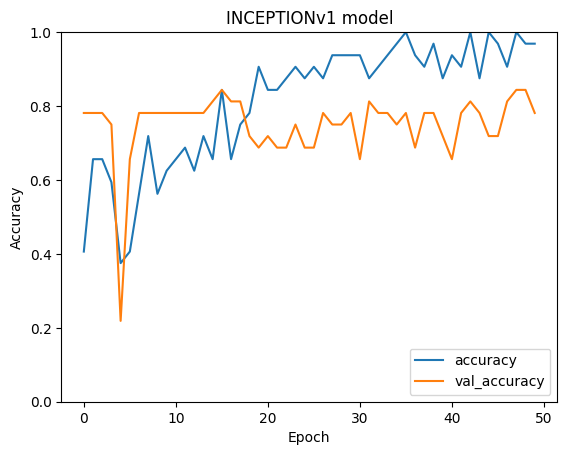

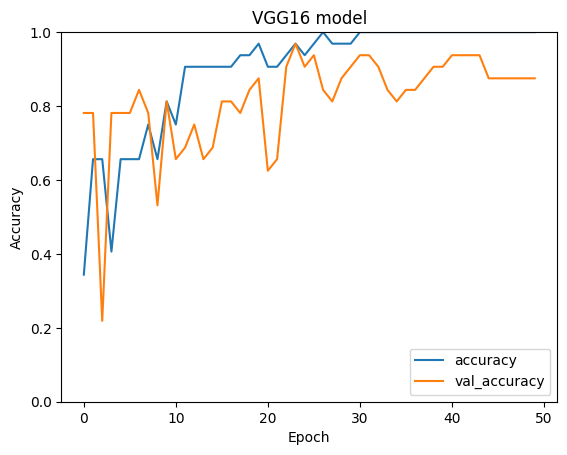

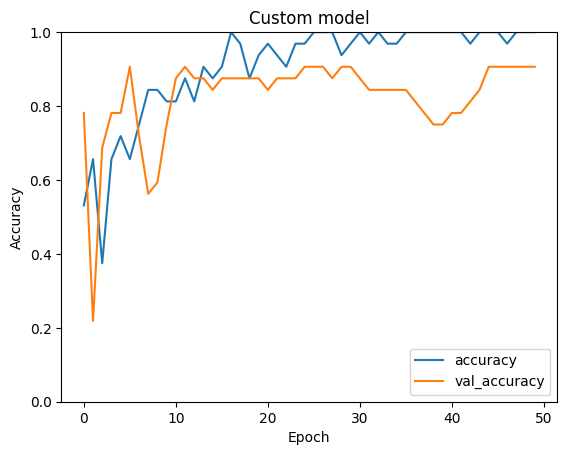

In [ ]:
plot_training_accuracy(inc_histo,"INCEPTIONv1 model")
plot_training_accuracy(vgg_histo,"VGG16 model")
plot_training_accuracy(custo_histo,"Custom model")

<h3>Test</h3>

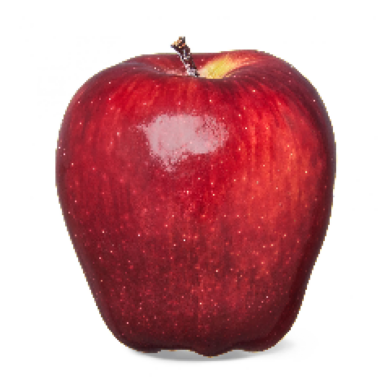

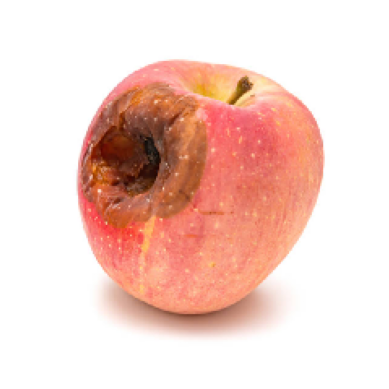

In [ ]:
h_test = load_image(parameters[3]['rh'],input_shape=parameters[2]['input_shape'],show=True)
r_test = load_image(parameters[3]['rr'],input_shape=parameters[2]['input_shape'],show=True)

In [ ]:
# test inceptionv1
icv1_h_test_pred = incv1.predict(h_test)
print(icv1_h_test_pred)
icv1_r_test_pred = incv1.predict(r_test)
print(icv1_r_test_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.5224215  0.47757855]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.51707715 0.4829228 ]]


<h2>Feature Maps</h2>


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Visualizing layer 1


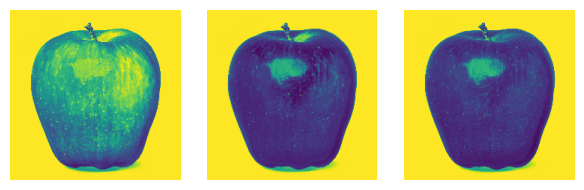

Visualizing layer 2


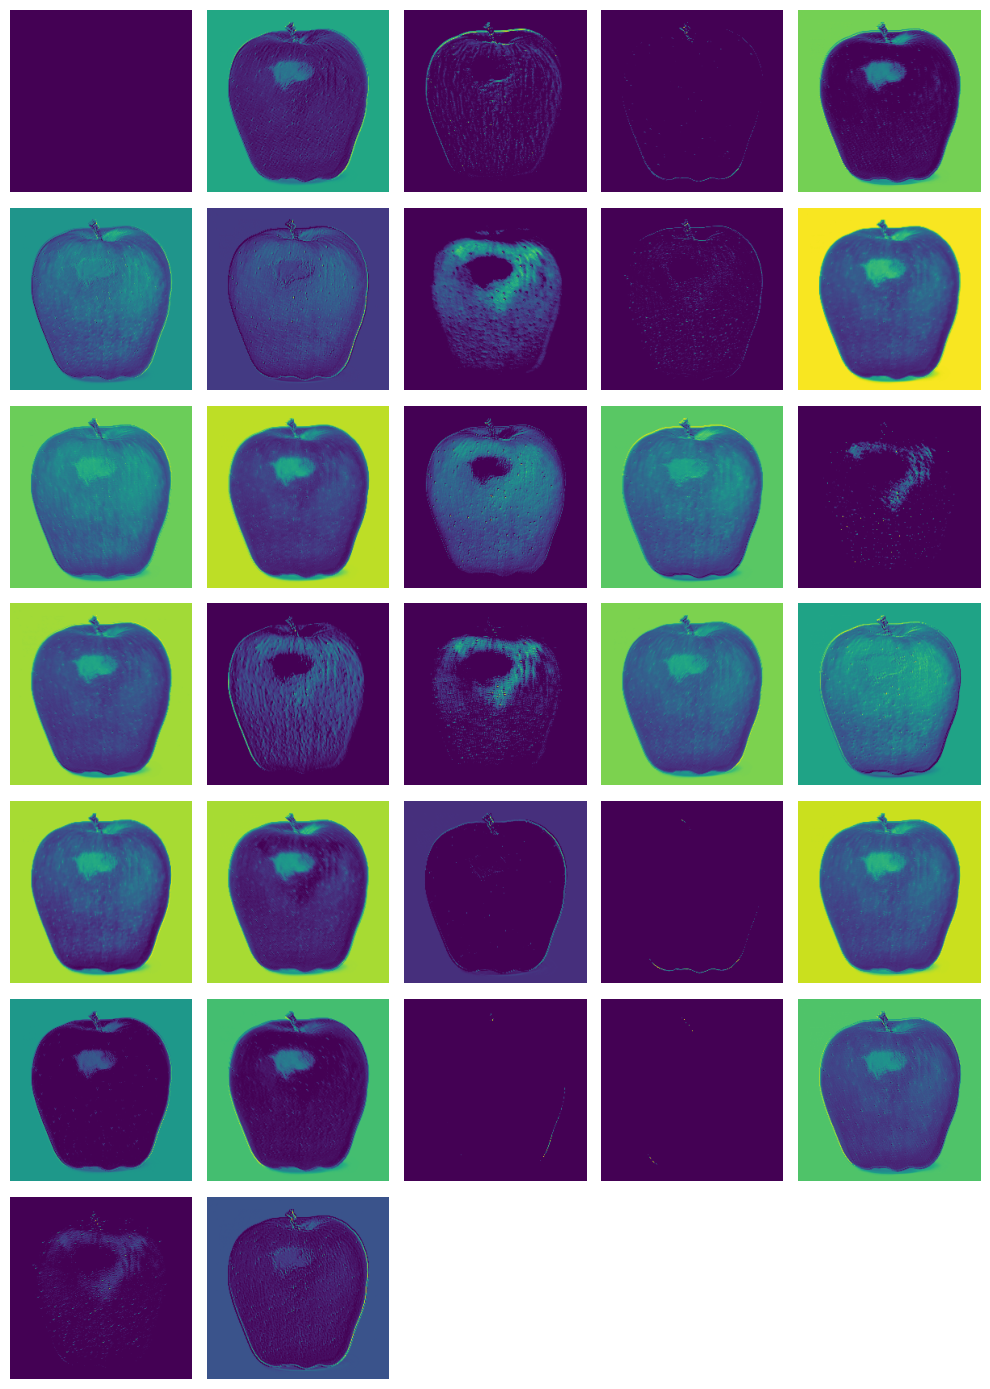

Visualizing layer 3


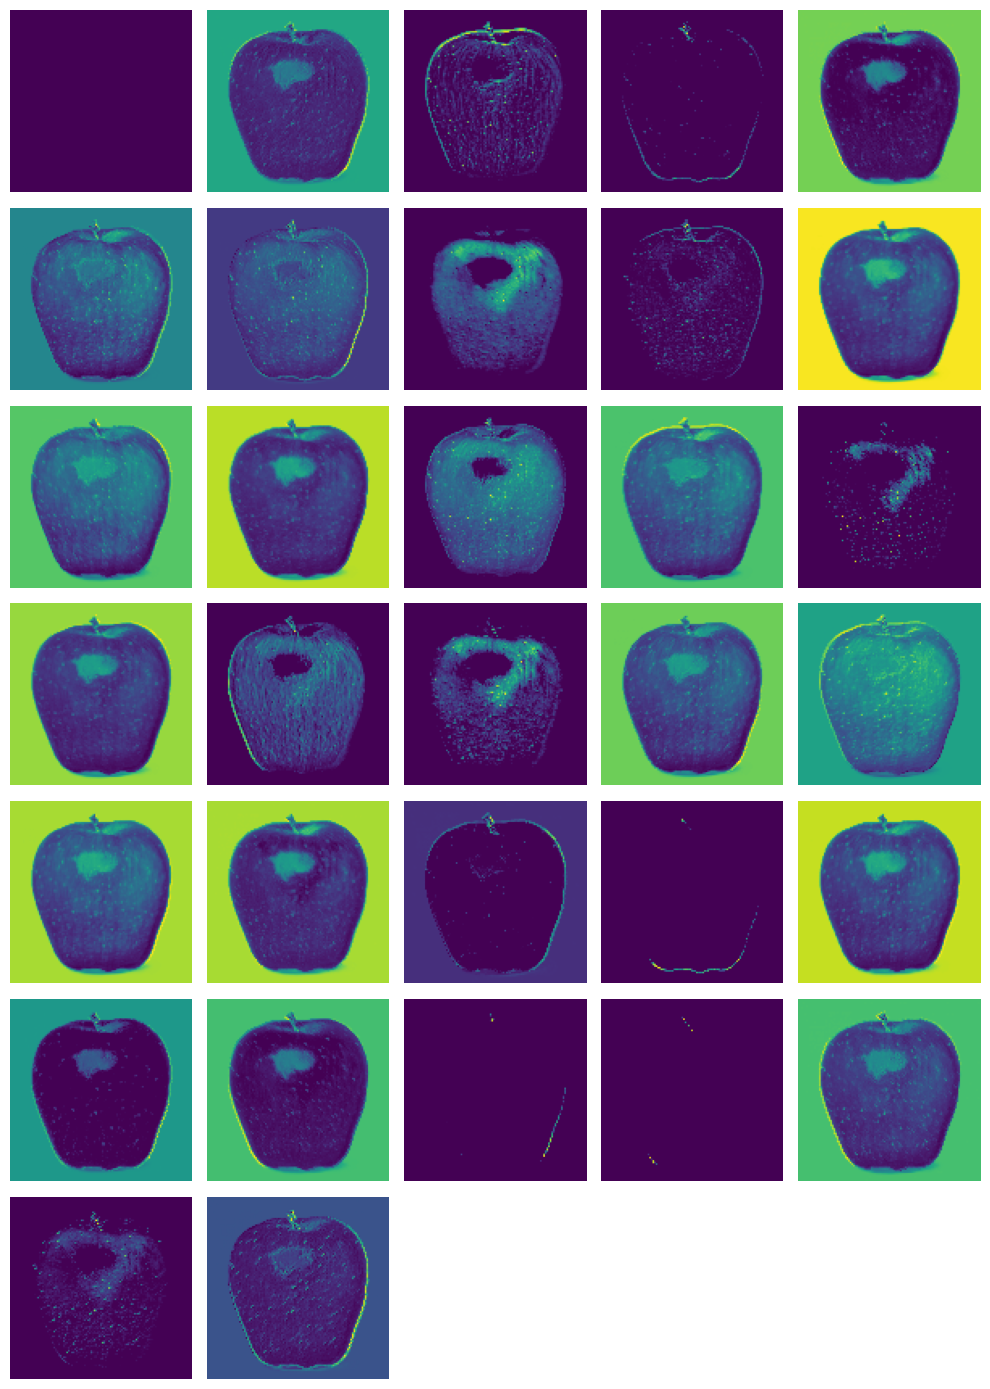

Visualizing layer 4


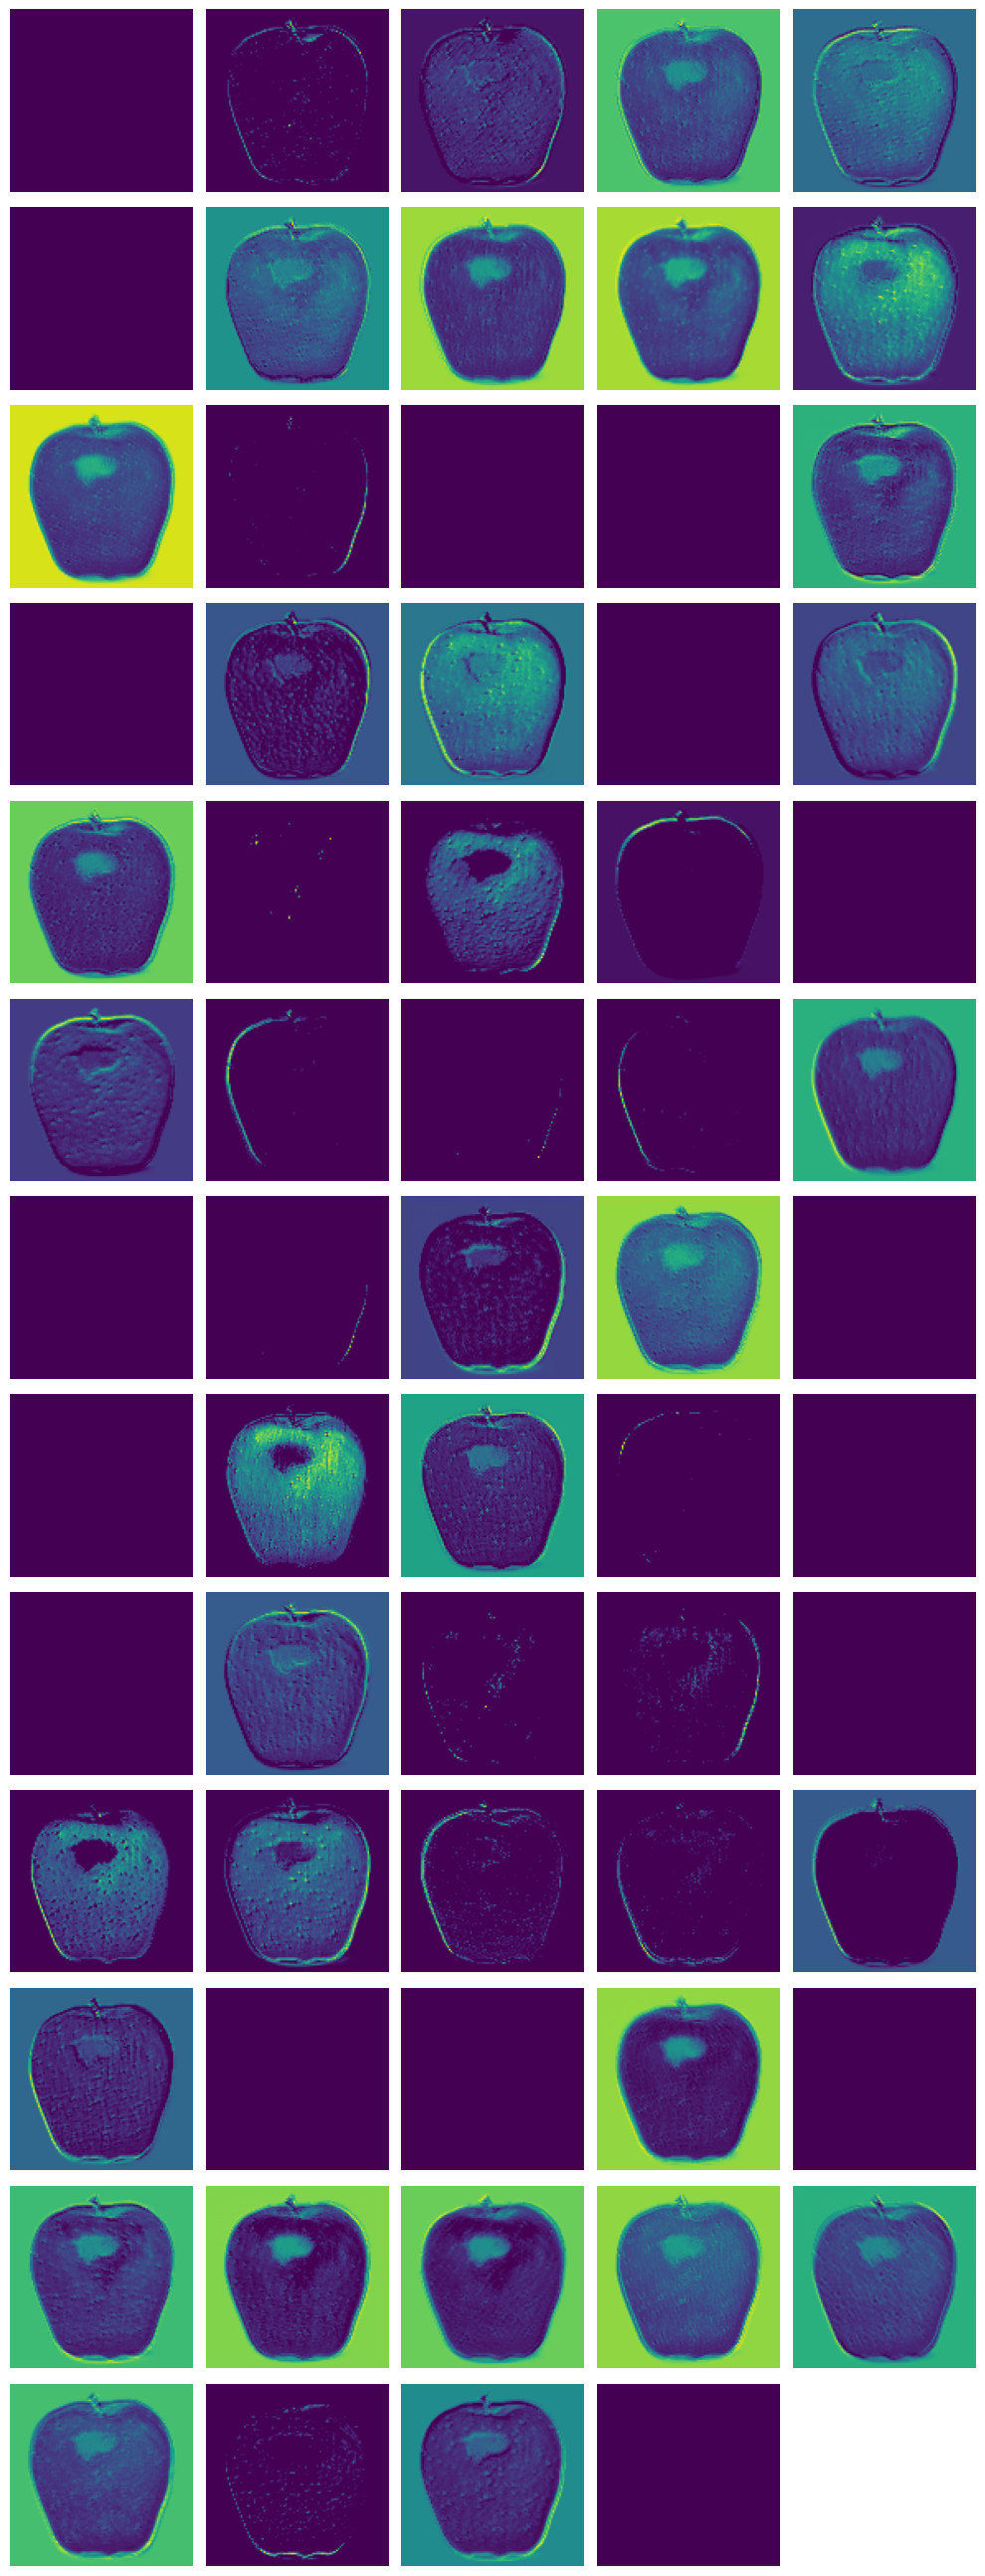

Visualizing layer 5


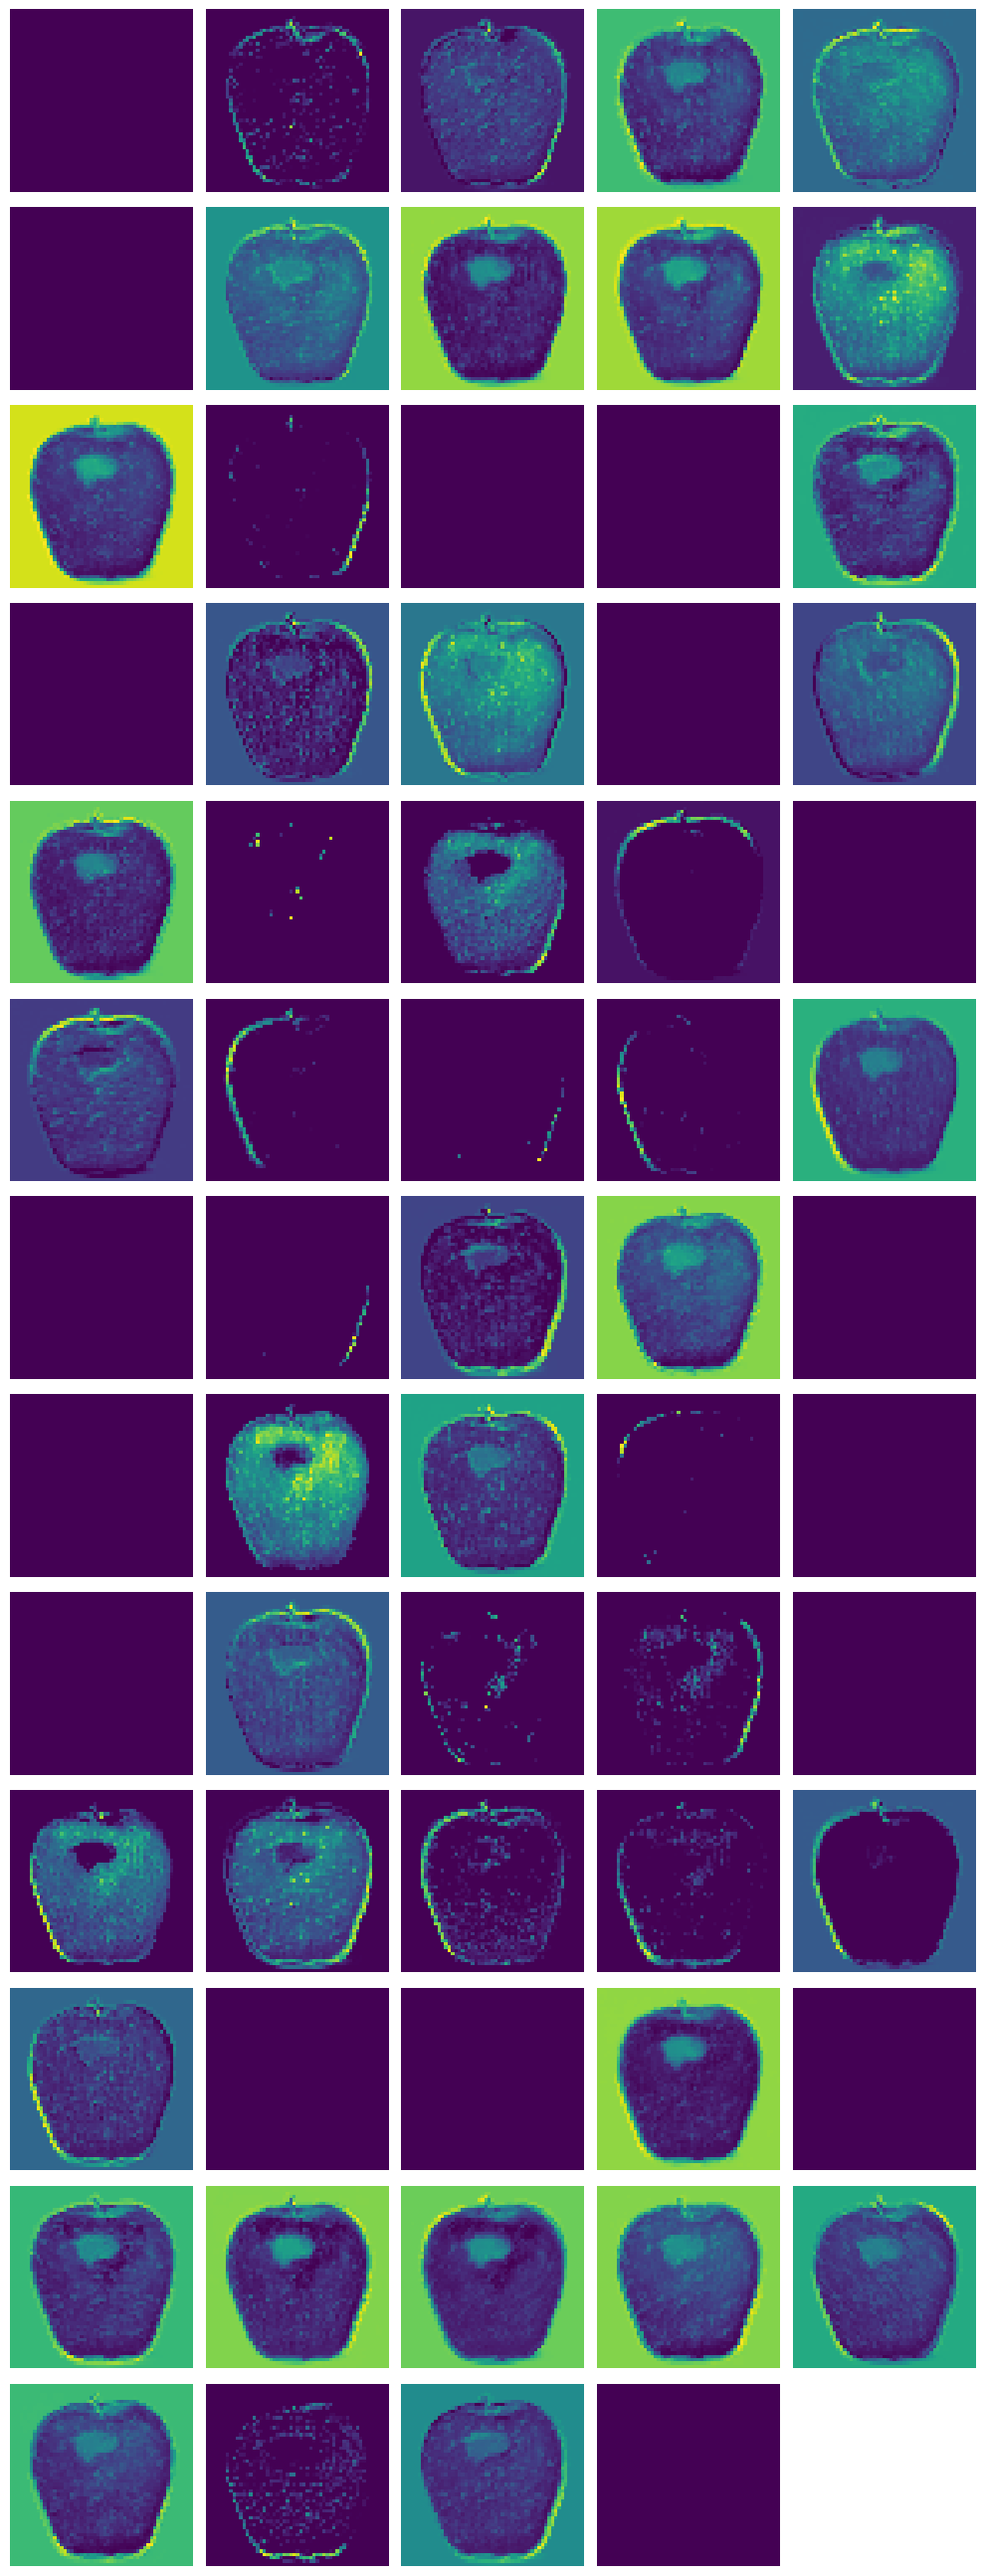

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Visualizing layer 1


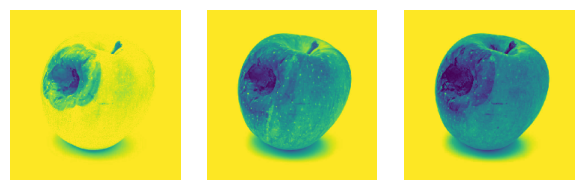

Visualizing layer 2


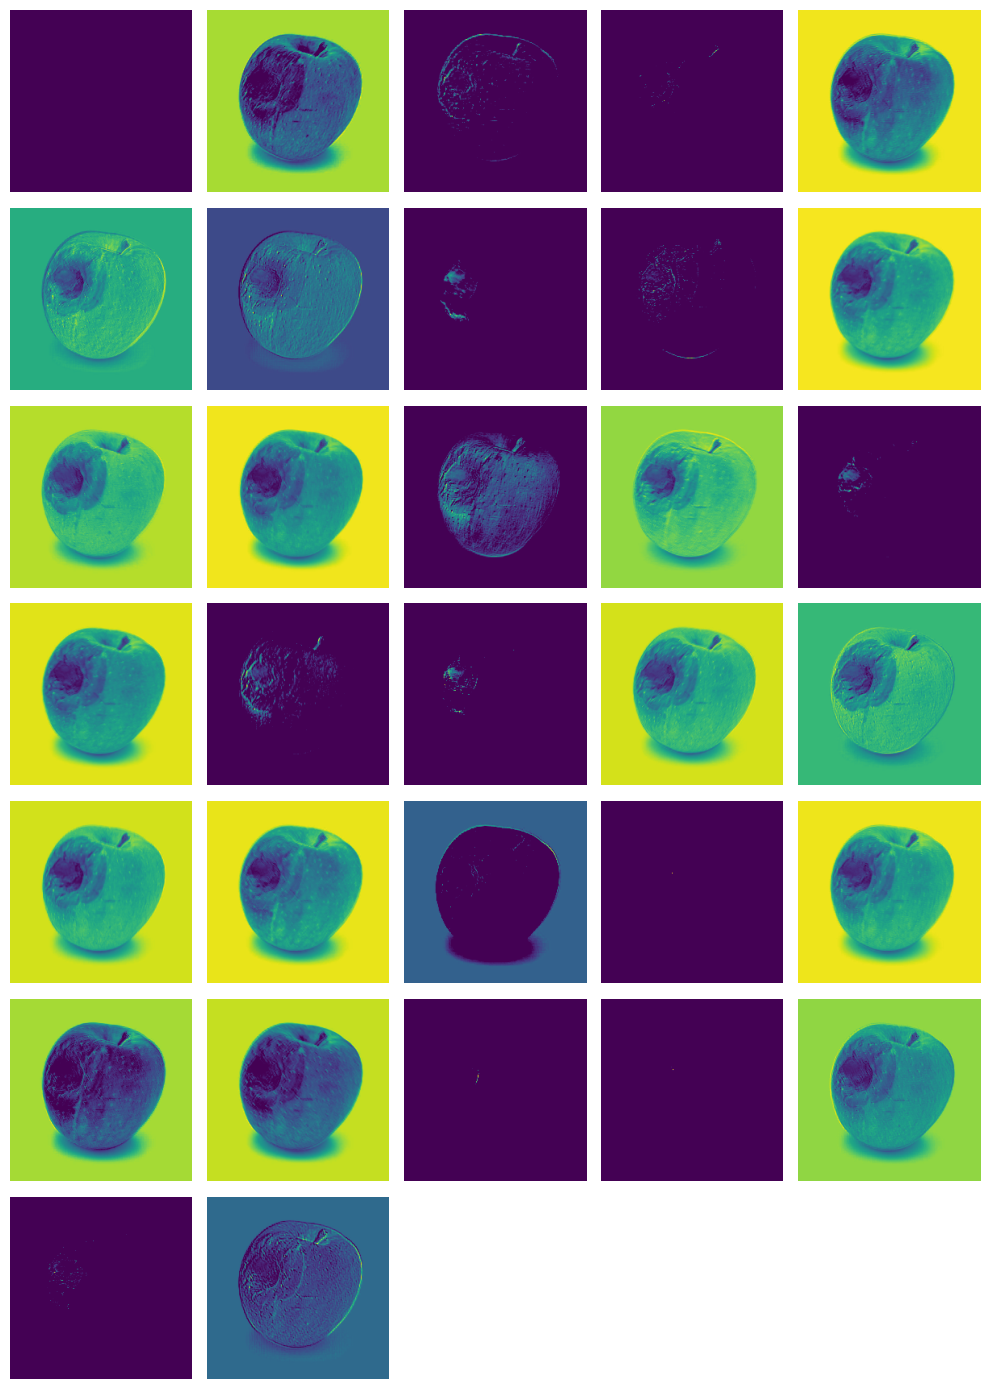

Visualizing layer 3


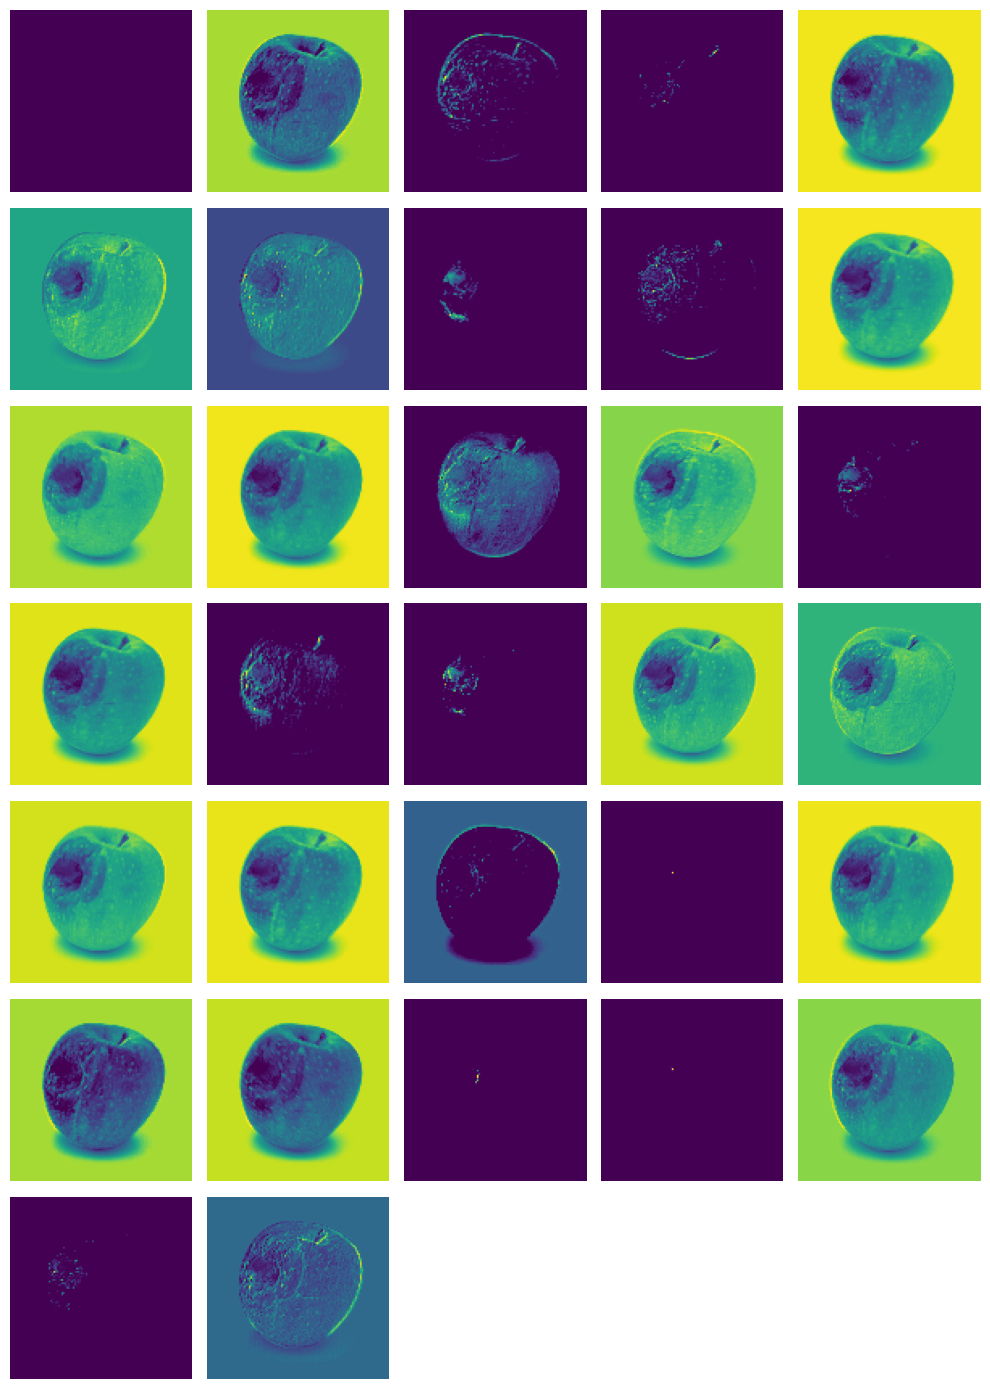

Visualizing layer 4


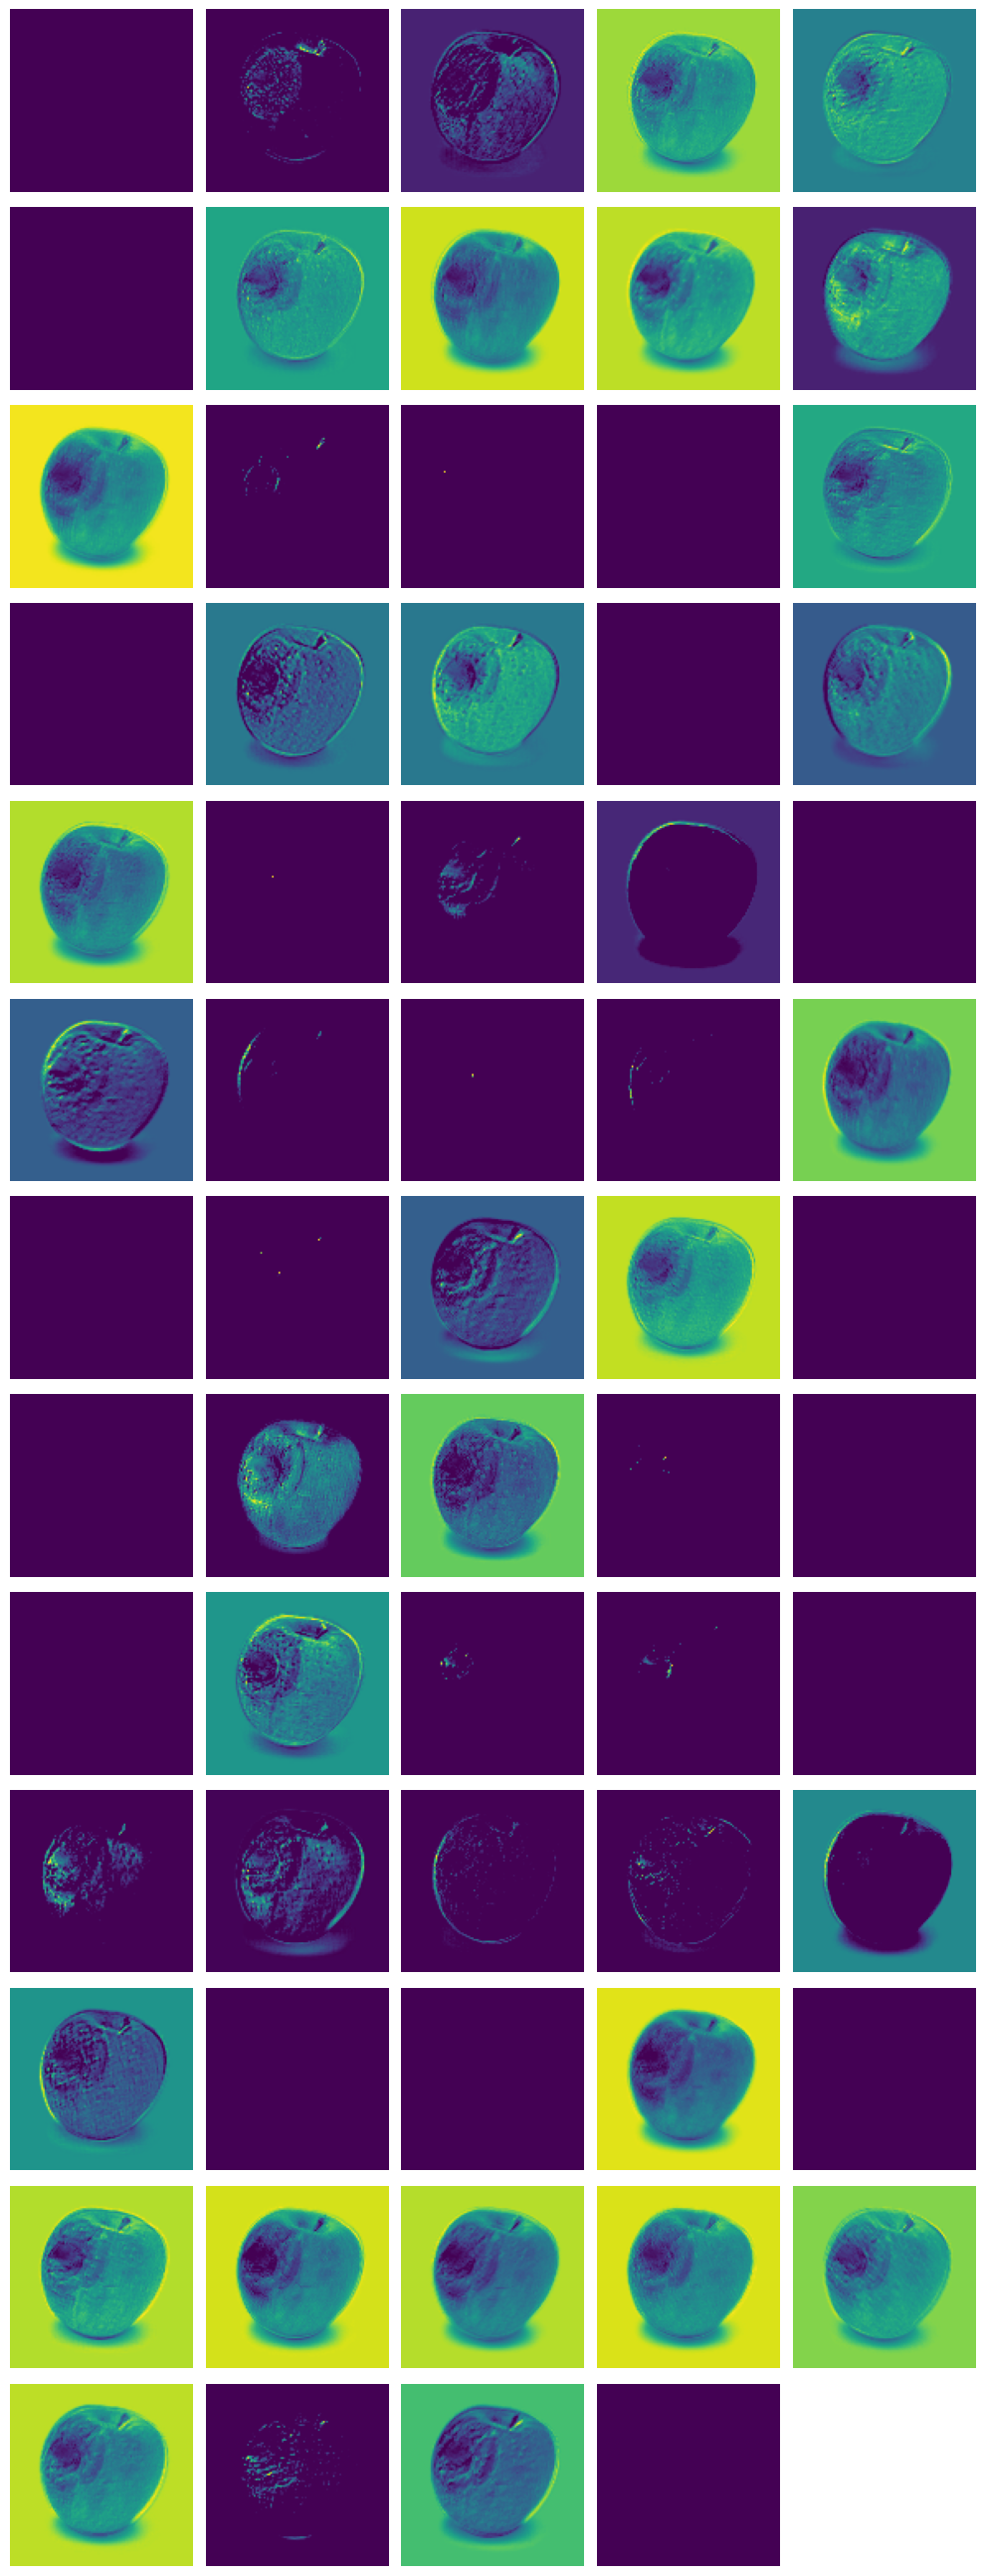

Visualizing layer 5


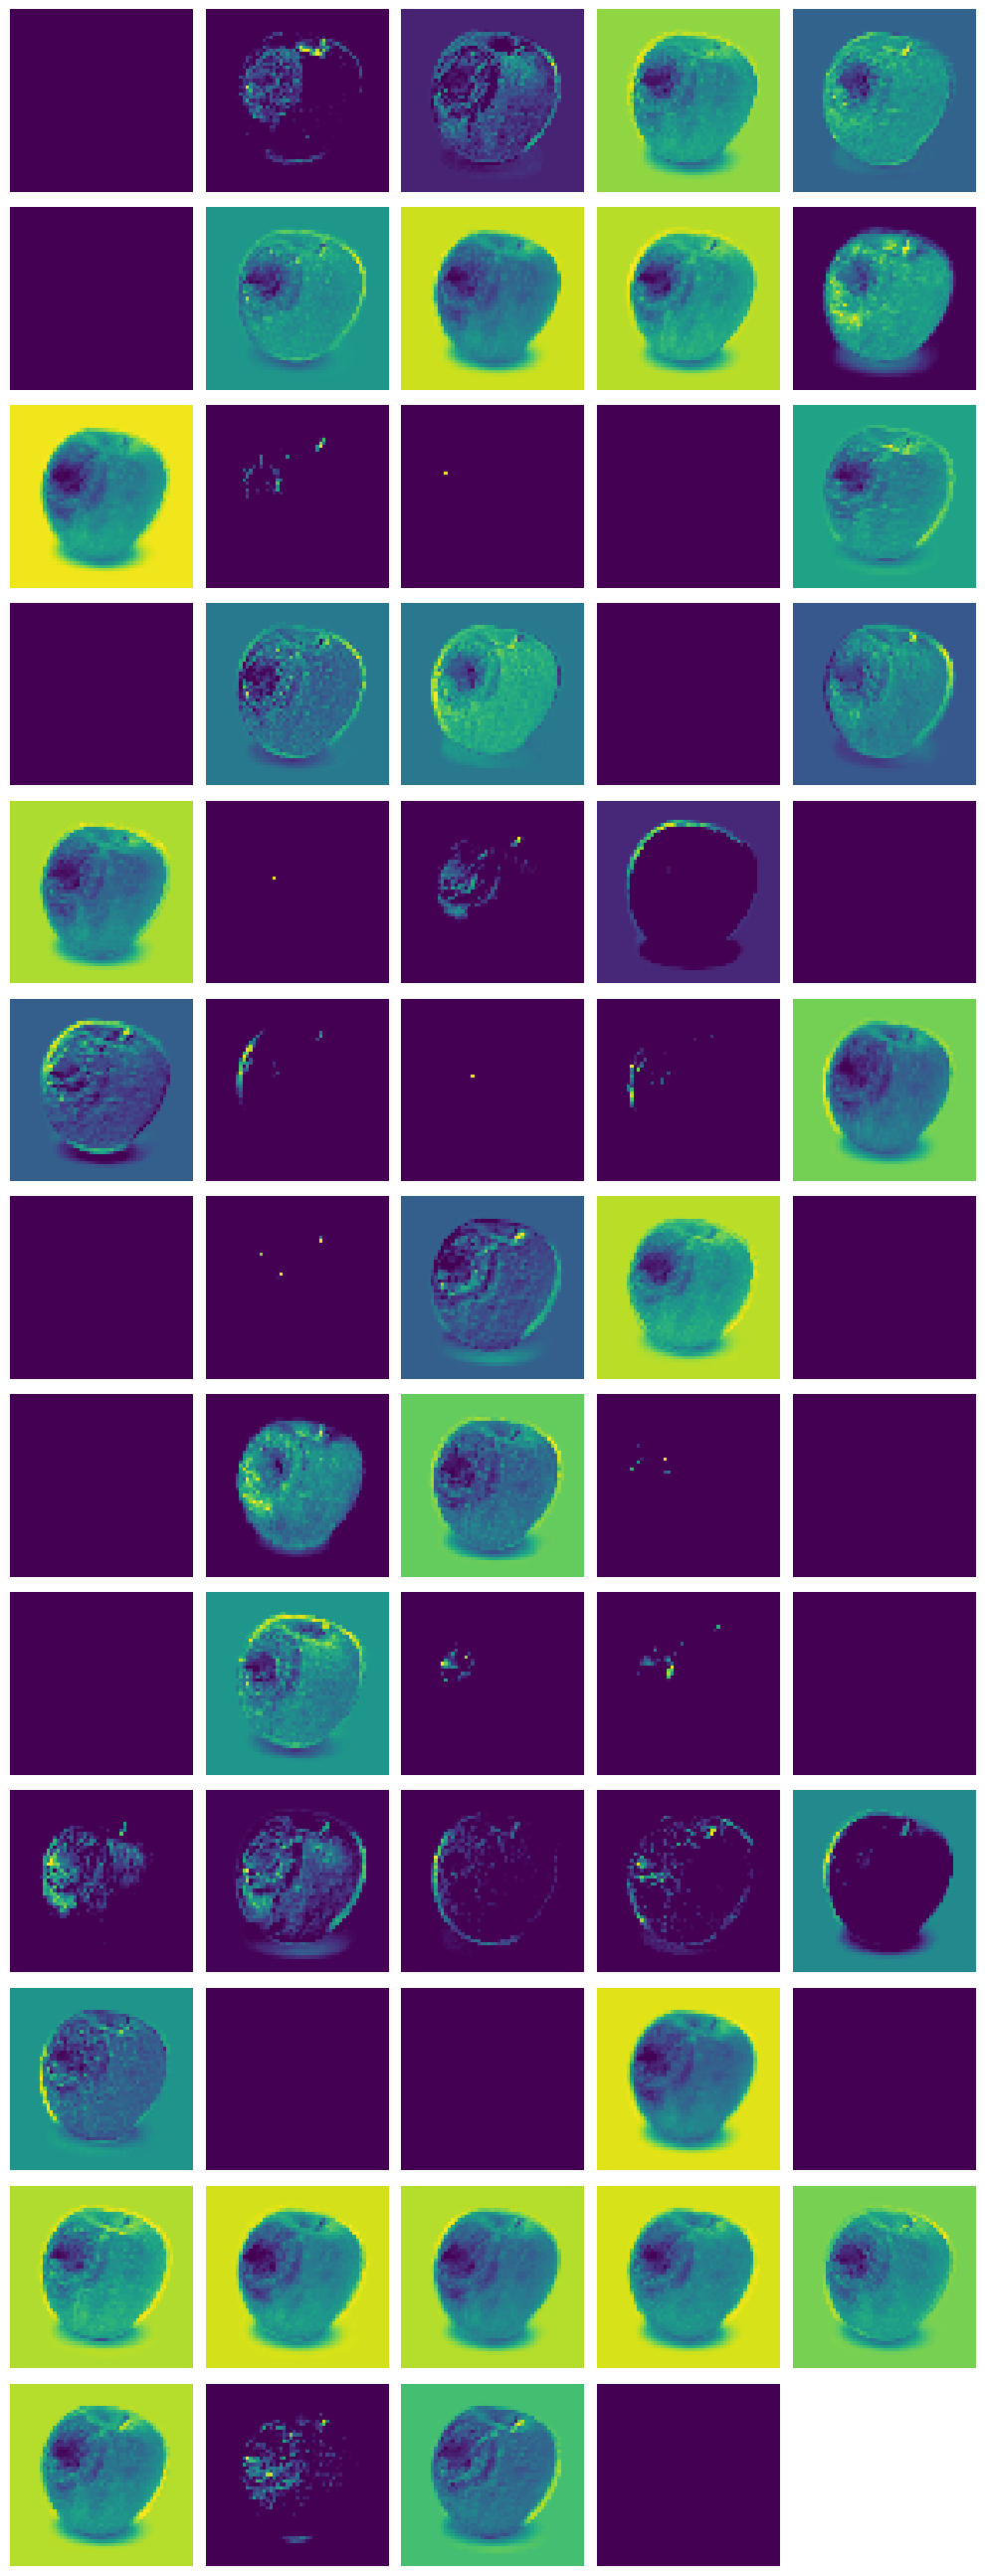

In [ ]:
# inceptionv1 feature map
get_feature_maps(h_test,custo,num_layers=5,cols=5)
get_feature_maps(r_test,custo,num_layers=5,cols=5)

<h2>Metrics</h2>

In [ ]:
#
est_loss, test_acc = incv1.evaluate(val_x, val_y, verbose=2)
print('incv1' + str(test_acc))

1/1 - 0s - 101ms/step - accuracy: 0.7812 - loss: 0.5248
incv10.78125


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0.61778694 0.38221306]
[0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0]
[0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0]
Matriz de Confusión:
[[19  6]
 [ 1  6]]
Reporte de Clasificación:
              precision    recall  f1-score   support

     healthy       0.95      0.76      0.84        25
      rotten       0.50      0.86      0.63         7

    accuracy                           0.78        32
   macro avg       0.72      0.81      0.74        32
weighted avg       0.85      0.78      0.80        32



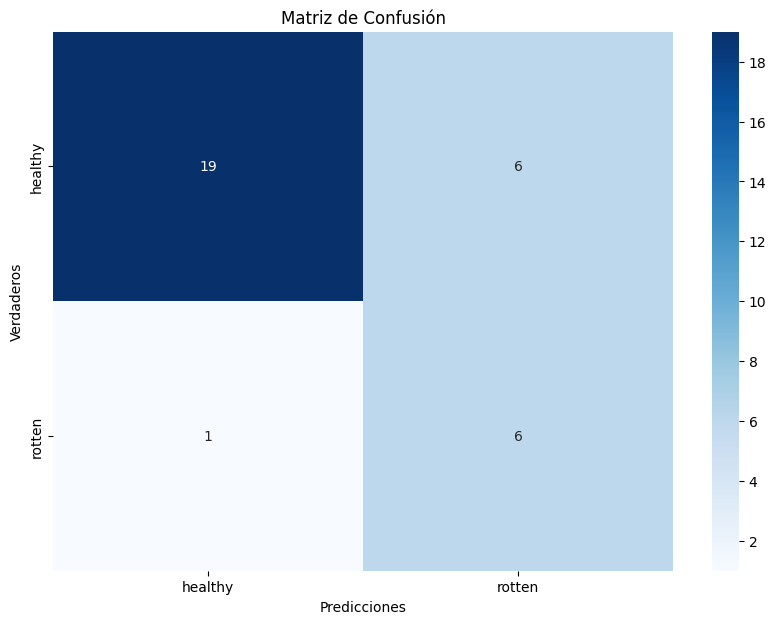

In [ ]:
val_x, val_y = next(iter(val_data))
val_predictions = incv1.predict(val_x)
print(val_predictions[10])
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(val_y, axis=1)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)
print(val_predictions_classes)
print(val_true_classes)
print("Matriz de Confusión:")
print(conf_matrix)
# Calcular las métricas
class_names = ['healthy','rotten']
report = classification_report(val_true_classes, val_predictions_classes, target_names= class_names)

print("Reporte de Clasificación:")
print(report)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

112/112 - 30s - 267ms/step - accuracy: 0.7798 - loss: 0.6129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1

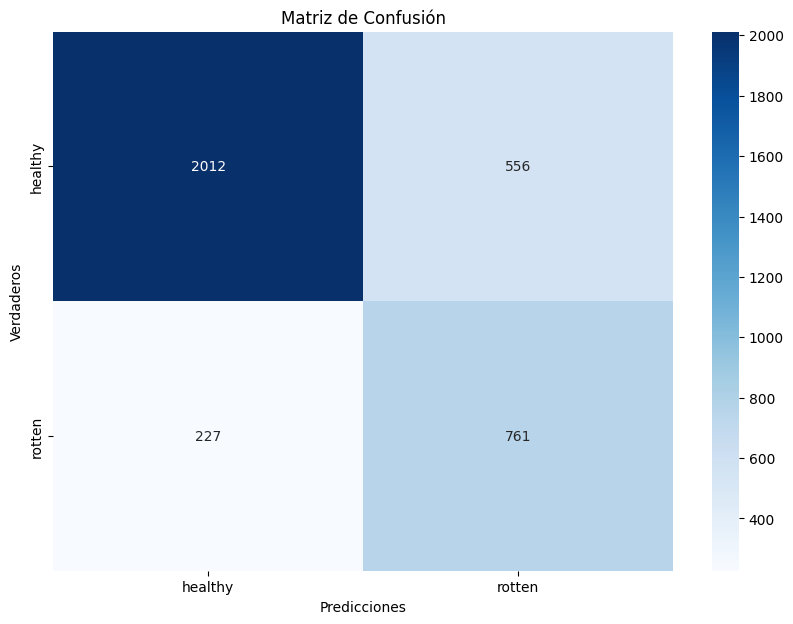

In [ ]:
# Evaluar en todo el conjunto de validación
val_loss, val_acc = incv1.evaluate(val_data, verbose=2)

# Obtener todas las predicciones y etiquetas verdaderas
val_predictions = []
val_true_classes = []

for val_x, val_y in val_data:
    val_predictions.extend(incv1.predict(val_x))
    val_true_classes.extend(np.argmax(val_y, axis=1))

val_predictions_classes = np.argmax(val_predictions, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)
print("Matriz de Confusión:")
print(conf_matrix)

# Calcular las métricas
report = classification_report(val_true_classes, val_predictions_classes, target_names=class_names)
print("Reporte de Clasificación:")
print(report)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.show()
#evaluate_model(incv1, val_data, class_names)

**Metricas modelo  VGG16**

112/112 - 28s - 247ms/step - accuracy: 0.7520 - loss: 3.7146
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━

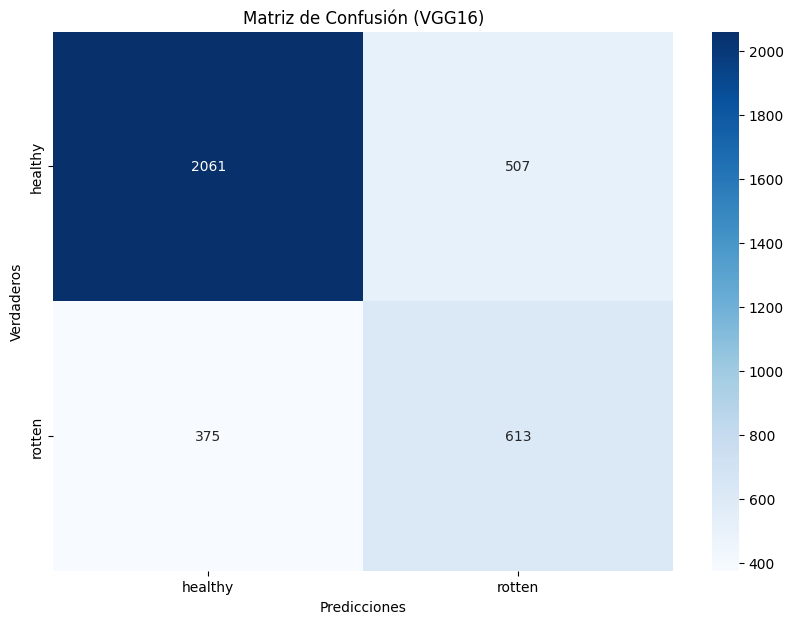

In [ ]:
# Evaluar en todo el conjunto de validación
val_loss_vgg, val_acc_vgg = vgg16.evaluate(val_data, verbose=2)

# Obtener todas las predicciones y etiquetas verdaderas
val_predictions_vgg = []
val_true_classes_vgg = []

for val_x, val_y in val_data:
    val_predictions_vgg.extend(vgg16.predict(val_x))
    val_true_classes_vgg.extend(np.argmax(val_y, axis=1))

val_predictions_classes_vgg = np.argmax(val_predictions_vgg, axis=1)

# Calcular la matriz de confusión
conf_matrix_vgg = confusion_matrix(val_true_classes_vgg, val_predictions_classes_vgg)
print("Matriz de Confusión (VGG16):")
print(conf_matrix_vgg)

# Calcular las métricas
report_vgg = classification_report(val_true_classes_vgg, val_predictions_classes_vgg, target_names=class_names)
print("Reporte de Clasificación (VGG16):")
print(report_vgg)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión (VGG16)')
plt.show()

 Modelo Custom

112/112 - 24s - 213ms/step - accuracy: 0.7874 - loss: 18.3854
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━

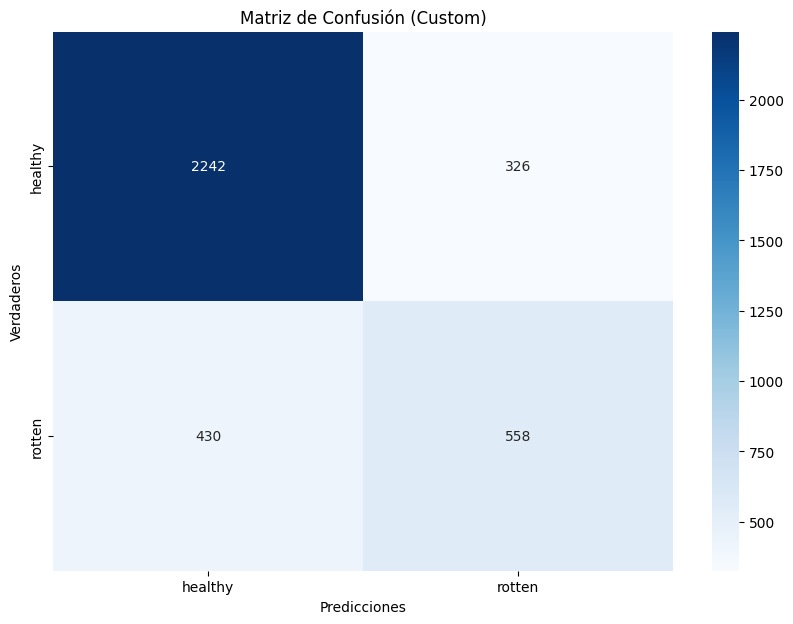

In [ ]:
# Evaluar en todo el conjunto de validación
val_loss_custo, val_acc_custo = custo.evaluate(val_data, verbose=2)

# Obtener todas las predicciones y etiquetas verdaderas
val_predictions_custo = []
val_true_classes_custo = []

for val_x, val_y in val_data:
    val_predictions_custo.extend(custo.predict(val_x))
    val_true_classes_custo.extend(np.argmax(val_y, axis=1))

val_predictions_classes_custo = np.argmax(val_predictions_custo, axis=1)

# Calcular la matriz de confusión
conf_matrix_custo = confusion_matrix(val_true_classes_custo, val_predictions_classes_custo)
print("Matriz de Confusión (Custom):")
print(conf_matrix_custo)

# Calcular las métricas
report_custo = classification_report(val_true_classes_custo, val_predictions_classes_custo, target_names=class_names)
print("Reporte de Clasificación (Custom):")
print(report_custo)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_custo, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión (Custom)')
plt.show()

<h3>Inceptionv3 transfer learning</h3>

In [ ]:

def build_icv3(input_shape, num_classes):
  # Example from the inceptionv3 application
  inception_v3 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the Inception v3 model to prevent them from being trained
  for layer in inception_v3.layers:
    layer.trainable = False

  # Create a new model on top of the Inception v3 base
  mod = Sequential()

  # Add the Inception v3 base model
  mod.add(inception_v3)

  # Add custom layers on top of the base model
  mod.add(layers.GlobalAveragePooling2D())
  mod.add(layers.Dense(1024, activation='relu'))
  mod.add(layers.Dropout(0.5))
  mod.add(layers.Dense(512, activation='relu'))
  mod.add(layers.Dropout(0.5))
  mod.add(layers.Dense(num_classes, activation='softmax'))

  return mod


In [ ]:
icv3 = build_icv3(parameters[2]['input_shape'], parameters[2]['classes'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
icv3.compile(optimizer=Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy']
               )